# 4 Data preprocessing - features selection

<b> Purpose of the action </b> - showing process of selecting the best features for different types of models using the perturbation technique (this process will be one part of pipeline in classification):
- Select example model of each type
- Fit model on training data
- Iteratively shuffle one feature at a time
- Check model accuracy and log loss on new dataset 
- Remove features if log loss is decreased

<b> </b>
<b> Action plan </b>:
- Perform features selection for different types of tree-based models:
    - RandomForestClassifier
    - AdaBoostClassifier
    - XGBClassifier
    - CatBoostClassifier
- Perform features selection for different types of linear and other models:
    - LogisticRegression
    - LinearSVC
    - SVC with RBF
    - KNeighborsClassifier
- Perform features selection for two types of deep learning models:
    - Simple ANN
    - RNN with LSTM layers
- Show features importances for all type of models
- Show difference in accuracy and log loss after shuffling each features for each models
- Compare accuracy and log loss for all models fitting on whole and reduced data sets. Sometimes the drop in accuracy is not bad, diversity is more important for future ensembling models

## 4.0 Import necessary libraries and modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from modeling import build_ann, build_rnn
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from data_preprocessing import plot_feature_importances, feature_reduction, feature_reduction_deep_learning, \
                               calculate_base_metrics, show_base_metrics, show_acc_log_loss_difference, \
                               show_diff_after_shuffling

##  4.1 Features selection for tree-based models

### 4.1.1 Read datasets dedicated for tree-based models

In [2]:
train_set = pd.read_csv("./preprocessed_data/processed_base_train_set.csv", index_col=0)
validation_set = pd.read_csv("./preprocessed_data/processed_base_validation_set.csv", index_col=0)
test_set = pd.read_csv("./preprocessed_data/processed_base_test_set.csv", index_col=0)

In [3]:
train_set.head()

,FTR,HomeTeamWinStreak3,HomeTeamWinStreak5,HomeTeamLossStreak3,HomeTeamLossStreak5,AwayTeamWinStreak3,AwayTeamWinStreak5,AwayTeamLossStreak3,AwayTeamLossStreak5,IsHomeTeamRegulars,...,HomeTeamGoalsLost,AwayTeamGoalsLost,HomeTeamShootsMade,AwayTeamShootsMade,HomeTeamTargetShootsMade,AwayTeamTargetShootsMade,HomeTeamCorners,AwayTeamCorners,HomeTeamTotalPoints,AwayTeamTotalPoints
0,1.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,-0.654654,...,-1.520338,-1.321356,-1.166204,-1.288115,-0.915460,-1.077353,-1.563681,-1.704033,-1.231720,-1.409469
1,1.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,-0.654654,...,-1.122373,-1.454010,-1.257637,-1.227160,-1.023389,-1.023389,-1.405785,-1.528593,-1.409469,-1.113220
2,0.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,1.527525,...,-1.321356,-1.652993,-1.349071,-1.013815,-1.077353,-0.807532,-1.493505,-1.546137,-1.290969,-1.053971
3,0.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,-0.654654,...,-1.520338,-1.321356,-1.196682,-1.166204,-0.969424,-0.915460,-1.405785,-1.633857,-1.290969,-1.468718
4,1.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,-0.654654,...,-1.255028,-1.586665,-1.135726,-1.227160,-0.807532,-0.915460,-1.300521,-1.546137,-1.527968,-1.113220


### 4.1.2 Split datasets to feature and label sets

In [4]:
X_train, y_train = train_set.drop(columns='FTR'), train_set['FTR']
X_valid, y_valid = validation_set.drop(columns='FTR'), validation_set['FTR']
X_test, y_test = test_set.drop(columns='FTR'), test_set['FTR']

In [5]:
y_test

0      0.0
1      1.0
2      1.0
3      0.0
4      1.0
      ... 
185    1.0
186    1.0
187    0.0
188    0.0
189    0.0
Name: FTR, Length: 190, dtype: float64

### 4.1.3 Perform features selection for CatBoostClassifier model using perturbation technique

#### 4.1.3.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [6]:
clf = CatBoostClassifier(random_state=42, n_estimators=400, max_depth=9, verbose=0)
clf.fit(X_train, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train, 
                                                                                                  y_train, 
                                                                                                  X_valid, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for CatBoostClassifier
Accuracy score on train set: 1.0
Accuracy score on valid set: 0.74
Base log loss result on train set: 0.16
Base log loss result on valid set: 0.55


#### 4.1.3.2 Check feature importance for this model

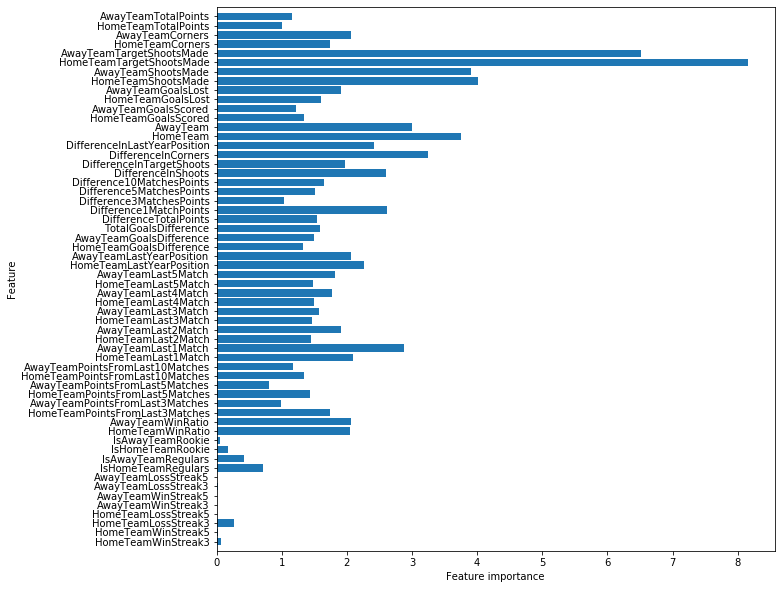

Number of features before reduction: 58


In [7]:
# funtion from preprocessing.py
plot_feature_importances(clf, X_train.columns)

print('Number of features before reduction:', len(X_train.columns))

#### 4.1.3.3 Reduce number of features using perturbation technique

In [8]:
# function return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'AwayTeamLossStreak3', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'IsHomeTeamRookie', 'IsAwayTeamRookie', 'HomeTeamWinRatio', 'AwayTeamWinRatio', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference', 'AwayTeamGoalsDifference', 'TotalGoalsDifference', 'DifferenceTotalPoints', 'Difference1MatchPoints', 'Difference3MatchesPoints', 'Difference5MatchesPoints', 'Difference10MatchesPoints', 'DifferenceInShoots', 'DifferenceInTargetShoots', 'DifferenceInCorners', 'DifferenceInLas

#### 4.1.3.4 Show difference in accuracy and log loss after shuffling each features

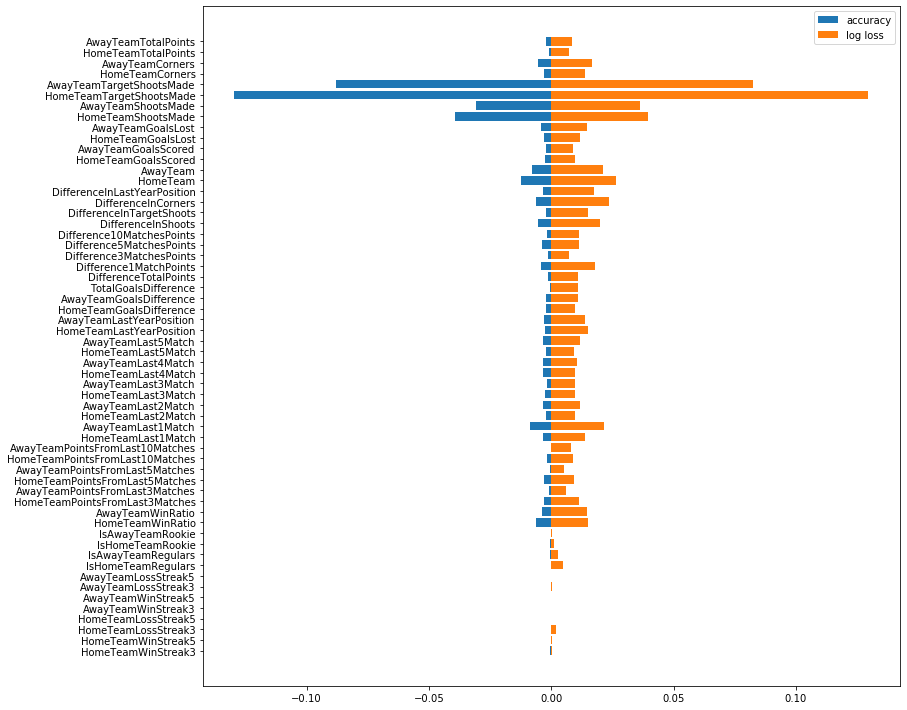

In [9]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.1.3.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [10]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

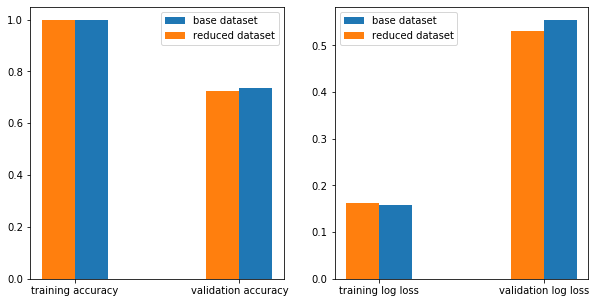

In [11]:
# fit new model on reduced dataset
clf = CatBoostClassifier(random_state=42, n_estimators=400, max_depth=9, verbose=0)
clf.fit(X_train_red, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red, 
                                                                                                              y_train, 
                                                                                                              X_valid_red, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)

### 4.1.4 Perform features selection for RandomForestClassifier model using perturbation technique

#### 4.1.4.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [12]:
clf = RandomForestClassifier(random_state=42, n_estimators=600, max_depth=19, verbose=0) 
clf.fit(X_train, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train, 
                                                                                                  y_train, 
                                                                                                  X_valid, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for RandomForestClassifier
Accuracy score on train set: 1.0
Accuracy score on valid set: 0.68
Base log loss result on train set: 0.17
Base log loss result on valid set: 0.58


#### 4.1.4.2 Check feature importance for this model

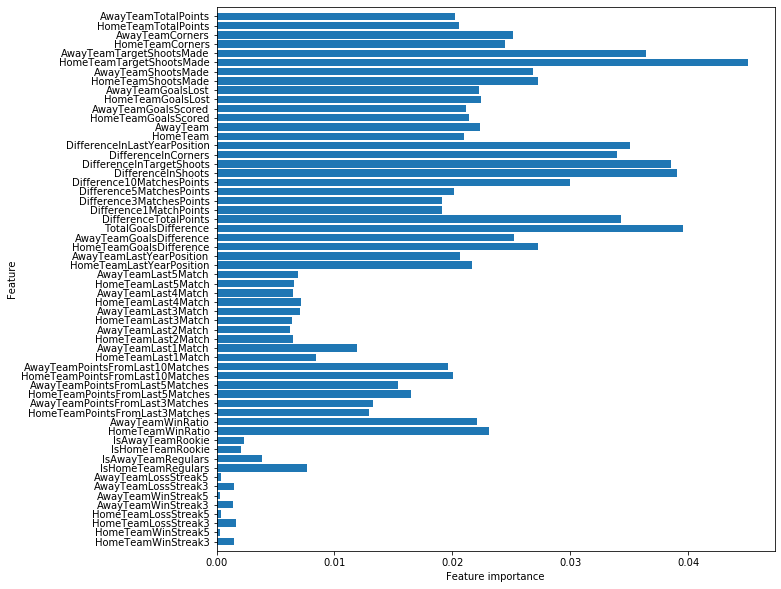

Number of features before reduction: 58


In [13]:
# funtion from preprocessing.py
plot_feature_importances(clf, X_train.columns)

print('Number of features before reduction:', len(X_train.columns))

#### 4.1.4.3 Reduce number of features using perturbation technique

In [14]:
# function return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'HomeTeamLossStreak5', 'AwayTeamWinStreak3', 'AwayTeamWinStreak5', 'AwayTeamLossStreak3', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'IsHomeTeamRookie', 'IsAwayTeamRookie', 'HomeTeamWinRatio', 'AwayTeamWinRatio', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference', 'AwayTeamGoalsDifference', 'TotalGoalsDifference', 'DifferenceTotalPoints', 'Difference1MatchPoints', 'Difference3MatchesPoints', 'Difference5MatchesPoints', 'Difference10MatchesPoints',

#### 4.1.4.4 Show difference in accuracy and log loss after shuffling each features

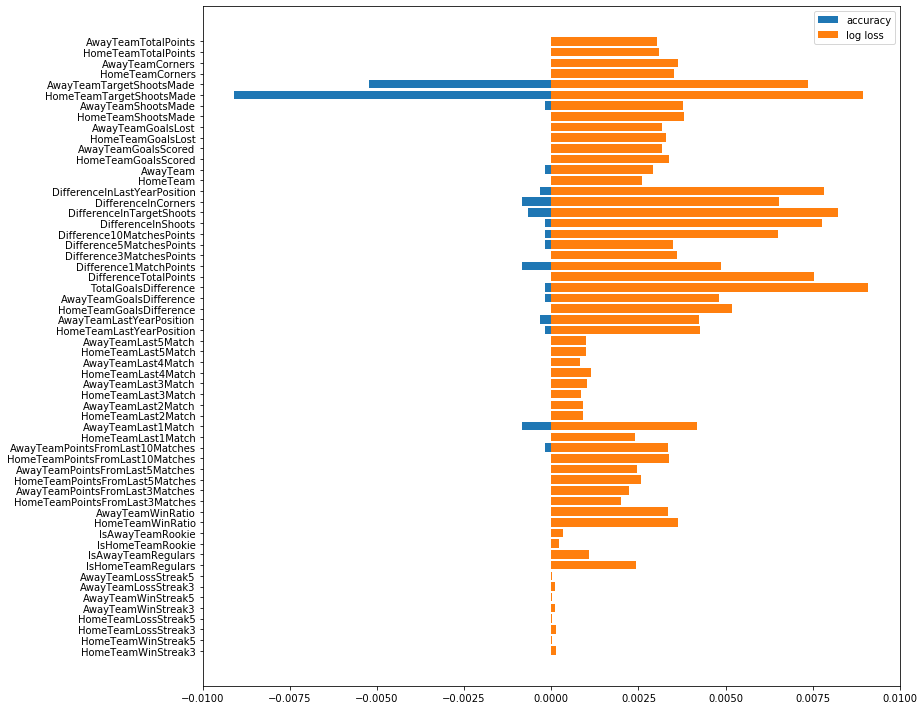

In [15]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.1.4.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [16]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

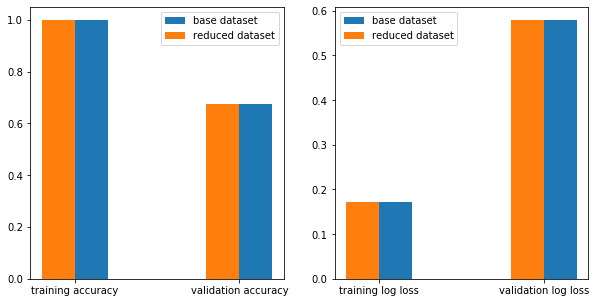

In [17]:
# fit new model on reduced dataset
clf = RandomForestClassifier(random_state=42, n_estimators=600, max_depth=19, verbose=0) 
clf.fit(X_train_red, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red, 
                                                                                                              y_train, 
                                                                                                              X_valid_red, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)

### 4.1.5 Perform features selection for XGBClassifier model using perturbation technique

#### 4.1.5.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [18]:
clf = XGBClassifier(subsample=0.8, 
                    scale_pos_weight=0.8,
                    reg_alpha=1e-05,
                    n_estimators=700,
                    min_child_weight=3,
                    max_depth=8,
                    learning_rate=0.01,
                    gamma=0.4,
                    colsample_bytree=0.7,
                    random_state=42,
                    verbose=0)
clf.fit(X_train, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train, 
                                                                                                  y_train, 
                                                                                                  X_valid, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for XGBClassifier
Accuracy score on train set: 0.95
Accuracy score on valid set: 0.72
Base log loss result on train set: 0.29
Base log loss result on valid set: 0.54


#### 4.1.5.2 Check feature importance for this model

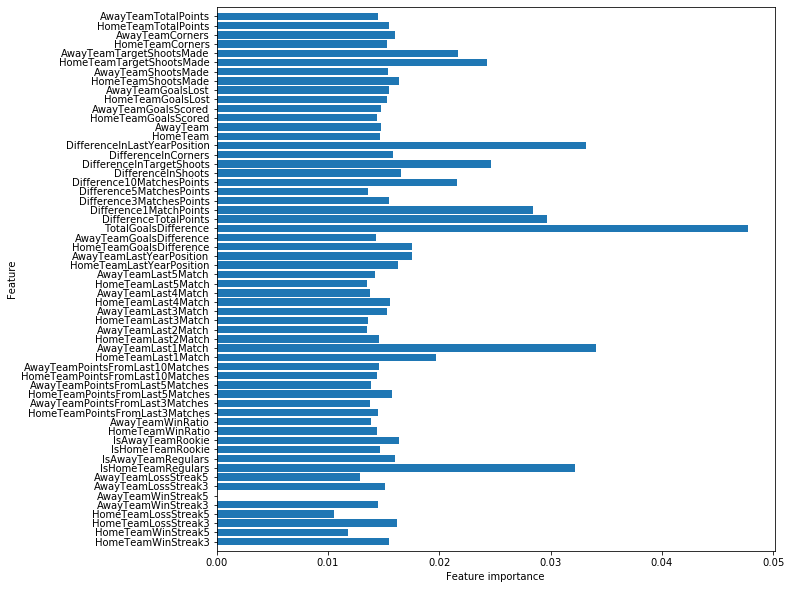

Number of features before reduction: 58


In [19]:
# funtion from preprocessing.py
plot_feature_importances(clf, X_train.columns)

print('Number of features before reduction:', len(X_train.columns))

#### 4.1.5.3 Reduce number of features using perturbation technique

In [20]:
# function return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'HomeTeamLossStreak5', 'AwayTeamWinStreak3', 'AwayTeamLossStreak3', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'IsHomeTeamRookie', 'IsAwayTeamRookie', 'HomeTeamWinRatio', 'AwayTeamWinRatio', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference', 'AwayTeamGoalsDifference', 'TotalGoalsDifference', 'DifferenceTotalPoints', 'Difference1MatchPoints', 'Difference3MatchesPoints', 'Difference5MatchesPoints', 'Difference10MatchesPoints', 'DifferenceInShoots',

#### 4.1.5.4 Show difference in accuracy and log loss after shuffling each features

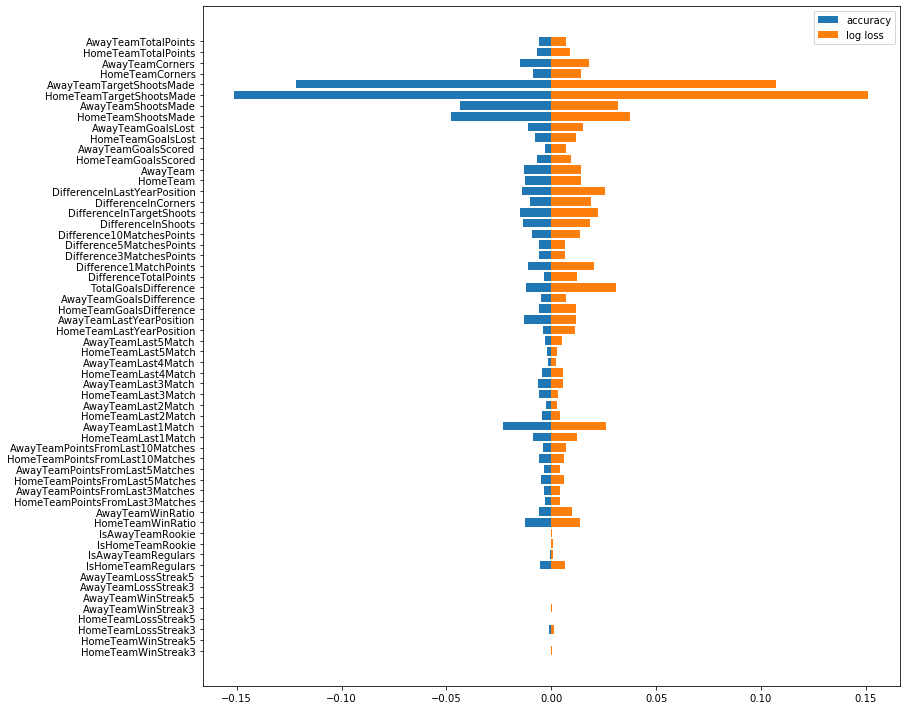

In [21]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.1.5.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [22]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

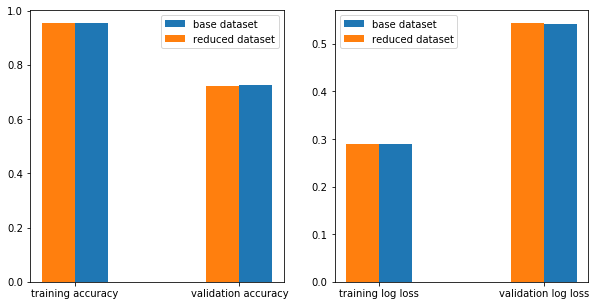

In [23]:
# fit new model on reduced dataset
clf = XGBClassifier(subsample=0.8, 
                    scale_pos_weight=0.8,
                    reg_alpha=1e-05,
                    n_estimators=700,
                    min_child_weight=3,
                    max_depth=8,
                    learning_rate=0.01,
                    gamma=0.4,
                    colsample_bytree=0.7,
                    random_state=42,
                    verbose=0)
clf.fit(X_train_red, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red, 
                                                                                                              y_train, 
                                                                                                              X_valid_red, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)

### 4.1.6 Perform features selection for AdaBoostClassifier model using perturbation technique

#### 4.1.6.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [24]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                         n_estimators=30,
                         learning_rate=0.6,
                         random_state=42)
clf.fit(X_train, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train, 
                                                                                                  y_train, 
                                                                                                  X_valid, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for AdaBoostClassifier
Accuracy score on train set: 0.69
Accuracy score on valid set: 0.69
Base log loss result on train set: 0.68
Base log loss result on valid set: 0.68


#### 4.1.6.2 Check feature importance for this model

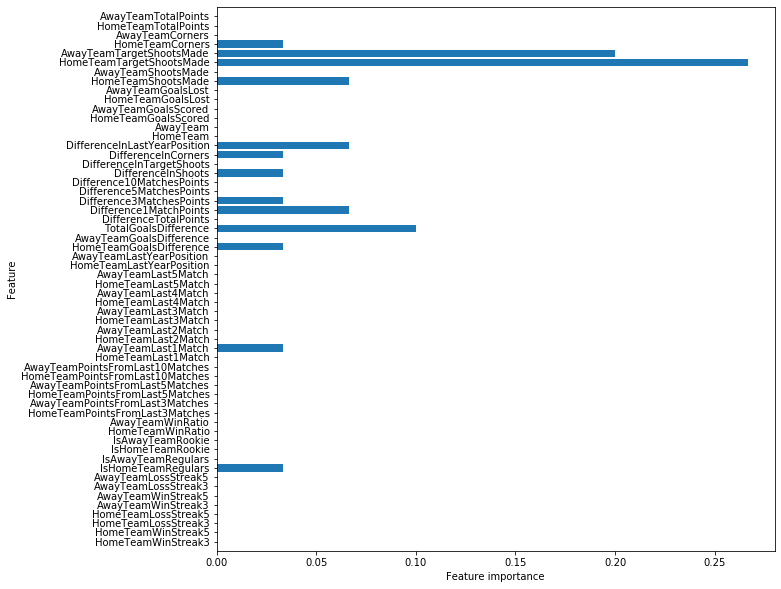

Number of features before reduction: 58


In [25]:
# funtion from preprocessing.py
plot_feature_importances(clf, X_train.columns)

print('Number of features before reduction:', len(X_train.columns))

#### 4.1.6.3 Reduce number of features using perturbation technique

In [26]:
# function return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['IsHomeTeamRegulars', 'AwayTeamLast1Match', 'HomeTeamGoalsDifference', 'TotalGoalsDifference', 'Difference1MatchPoints', 'Difference3MatchesPoints', 'DifferenceInShoots', 'DifferenceInCorners', 'DifferenceInLastYearPosition', 'HomeTeamTargetShootsMade', 'AwayTeamTargetShootsMade']
Number of features after reduction: 11


#### 4.1.6.4 Show difference in accuracy and log loss after shuffling each features

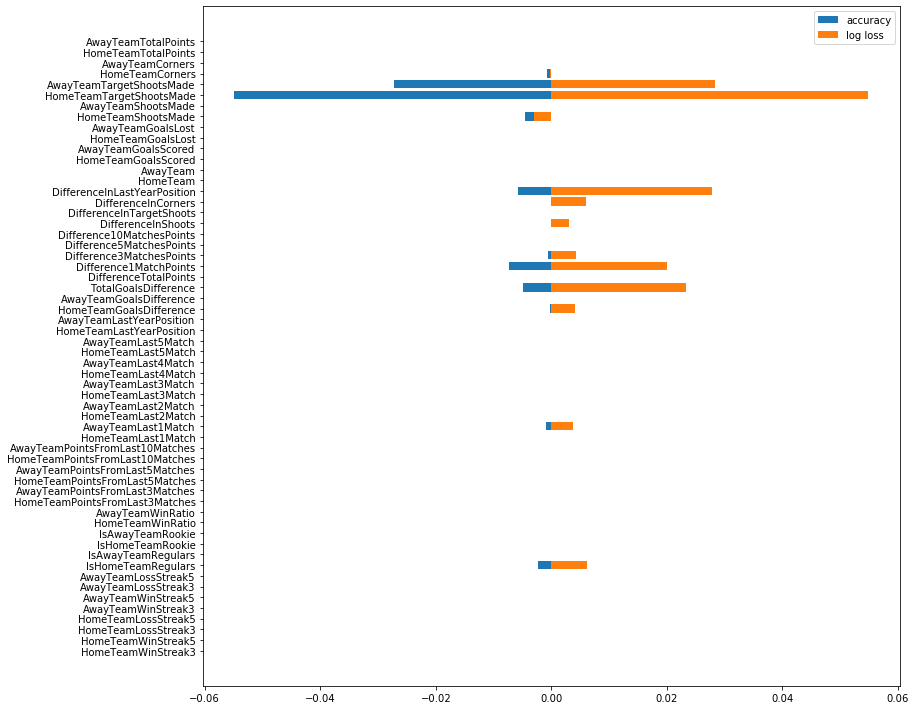

In [27]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.1.6.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [28]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

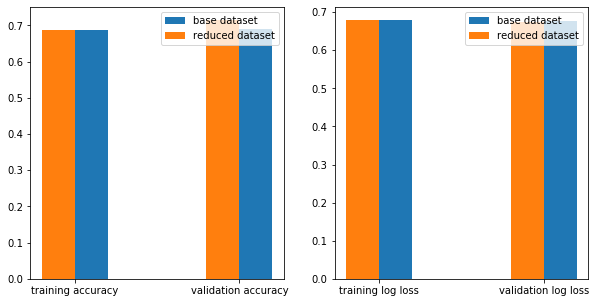

In [29]:
# fit new model on reduced dataset
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                         n_estimators=30,
                         learning_rate=0.6,
                         random_state=42)
clf.fit(X_train_red, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red, 
                                                                                                              y_train, 
                                                                                                              X_valid_red, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)

###  4.2 Features selection for linear and others models (Knn, Kernel's models)

### 4.2.1 Read datasets for linear models

In [30]:
train_set = pd.read_csv("./preprocessed_data/processed_categorical_train_set.csv", index_col=0)
validation_set = pd.read_csv("./preprocessed_data/processed_categorical_validation_set.csv", index_col=0)
test_set = pd.read_csv("./preprocessed_data/processed_categorical_test_set.csv", index_col=0)

In [31]:
train_set.head()

,FTR,HomeTeam,AwayTeam,HomeTeamWinStreak3,HomeTeamWinStreak5,HomeTeamLossStreak3,HomeTeamLossStreak5,AwayTeamWinStreak3,AwayTeamWinStreak5,AwayTeamLossStreak3,...,HomeTeamGoalsScored_Cat,AwayTeamGoalsScored_Cat,HomeTeamGoalsLost_Cat,AwayTeamGoalsLost_Cat,HomeTeamShootsMade_Cat,AwayTeamShootsMade_Cat,HomeTeamCorners_Cat,AwayTeamCorners_Cat,HomeTeamTotalPoints_Cat,AwayTeamTotalPoints_Cat
0,1.0,-0.933176,1.302727,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,...,-1.300392,-1.268051,-1.471048,-1.399792,-0.949548,-0.888699,-1.405459,-1.529962,-1.322546,-1.408152
1,1.0,-0.336793,-0.505750,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,...,-1.300392,-1.268051,-0.783231,-1.399792,-0.949548,-0.888699,-1.405459,-1.529962,-1.322546,-0.839221
2,0.0,0.507382,-2.052758,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,...,-1.300392,-0.482708,-1.471048,-1.399792,-0.949548,-0.888699,-1.405459,-1.529962,-1.322546,-0.839221
3,0.0,-0.343982,0.216670,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,...,-1.300392,-1.268051,-1.471048,-1.399792,-0.949548,-0.888699,-1.405459,-1.529962,-1.322546,-1.408152
4,1.0,-0.414523,0.510405,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,...,-1.300392,-1.268051,-1.471048,-1.399792,-0.949548,-0.888699,-1.405459,-1.529962,-1.322546,-0.839221


### 4.2.2 Split datasets to feature and label sets

In [32]:
X_train, y_train = train_set.drop(columns='FTR'), train_set['FTR']
X_valid, y_valid = validation_set.drop(columns='FTR'), validation_set['FTR']
X_test, y_test = test_set.drop(columns='FTR'), test_set['FTR']

### 4.2.3 Perform feature reduction for LinearSVC model using perturbation technique

#### 4.2.3.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [33]:
clf = SVC(kernel='linear', C=0.1, probability=True, random_state=42, verbose=0)
clf.fit(X_train, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train, 
                                                                                                  y_train, 
                                                                                                  X_valid, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for SVC
Accuracy score on train set: 0.69
Accuracy score on valid set: 0.67
Base log loss result on train set: 0.59
Base log loss result on valid set: 0.6


#### 4.2.3.2 Check feature importance for this model

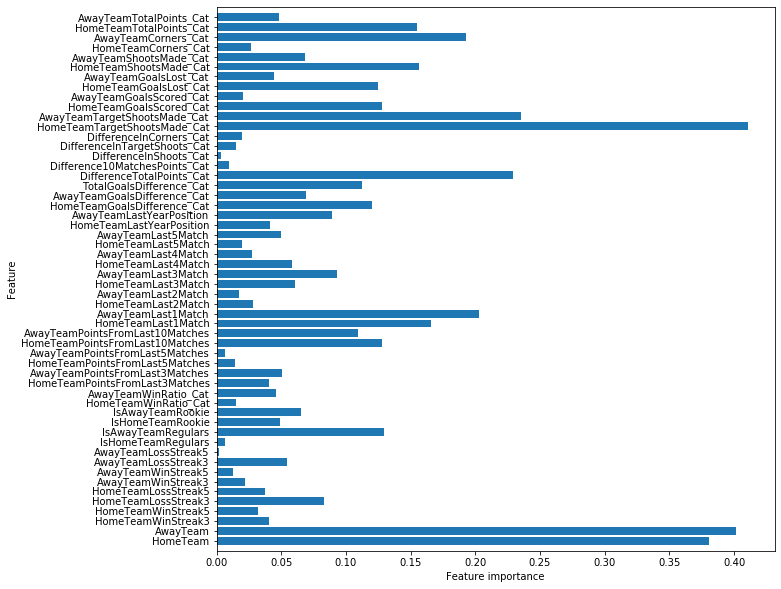

Number of features before reduction: 54


In [34]:
# funtion from preprocessing.py
plot_feature_importances(clf, X_train.columns)

print('Number of features before reduction:', len(X_train.columns))

#### 4.2.3.3 Reduce number of features using perturbation technique

In [35]:
# function return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeam', 'AwayTeam', 'HomeTeamWinStreak3', 'HomeTeamLossStreak3', 'AwayTeamWinStreak3', 'AwayTeamLossStreak3', 'AwayTeamLossStreak5', 'IsAwayTeamRegulars', 'IsHomeTeamRookie', 'IsAwayTeamRookie', 'AwayTeamWinRatio_Cat', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference_Cat', 'AwayTeamGoalsDifference_Cat', 'TotalGoalsDifference_Cat', 'DifferenceTotalPoints_Cat', 'Difference10MatchesPoints_Cat', 'DifferenceInTargetShoots_Cat', 'DifferenceInCorners_Cat', 'HomeTeamTargetShootsMade_Cat', 'AwayTeamTargetShootsMade_Cat', 'HomeTeamGoalsScored_Cat', 'AwayTeamGoalsScored_Cat', 'HomeTeam

#### 4.2.3.4 Show difference in accuracy and log loss after shuffling each features

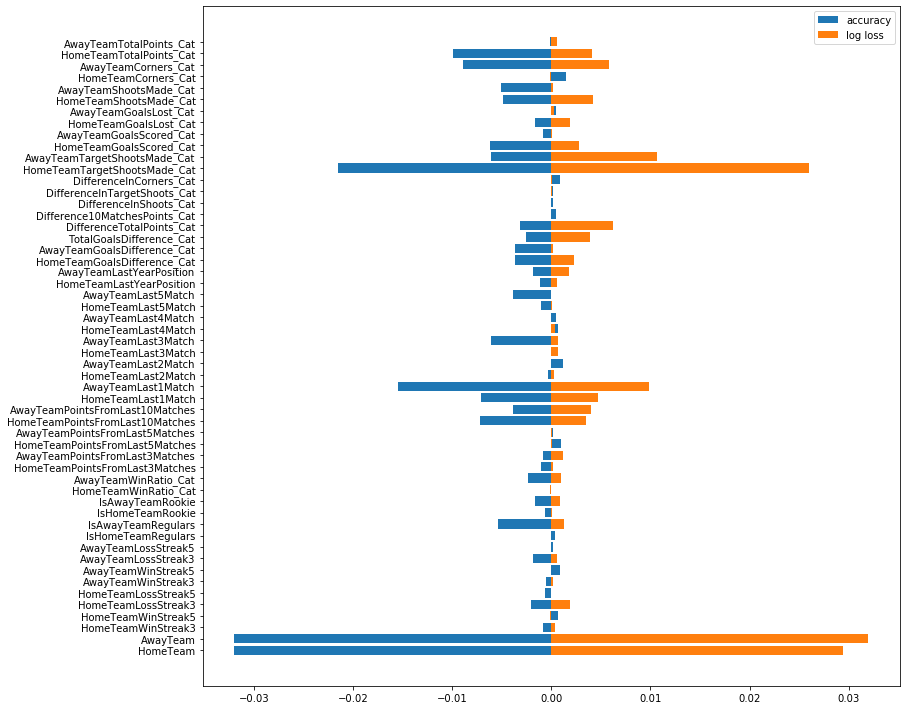

In [36]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.2.3.5 Compare accuracy for model fitting on whole and reduced dataset

In [37]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

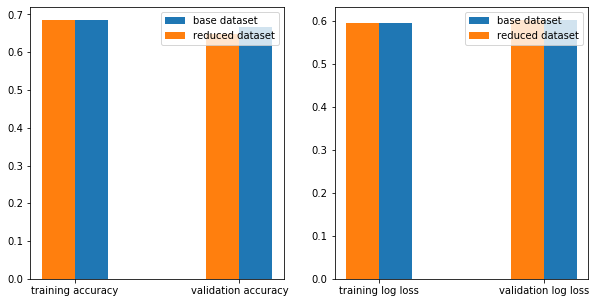

In [38]:
# fit new model on reduced dataset
clf = SVC(kernel='linear', C=0.1, probability=True, random_state=42, verbose=0)
clf.fit(X_train_red, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red, 
                                                                                                              y_train, 
                                                                                                              X_valid_red, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)

### 4.2.4 Perform features selection for LogisticRegression model using perturbation technique

#### 4.2.4.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [39]:
clf = LogisticRegression(random_state=42, C=0.1, max_iter=1000, verbose=0)
clf.fit(X_train, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train, 
                                                                                                  y_train, 
                                                                                                  X_valid, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for LogisticRegression
Accuracy score on train set: 0.68
Accuracy score on valid set: 0.65
Base log loss result on train set: 0.59
Base log loss result on valid set: 0.6


#### 4.2.4.2 Check feature importance for this model

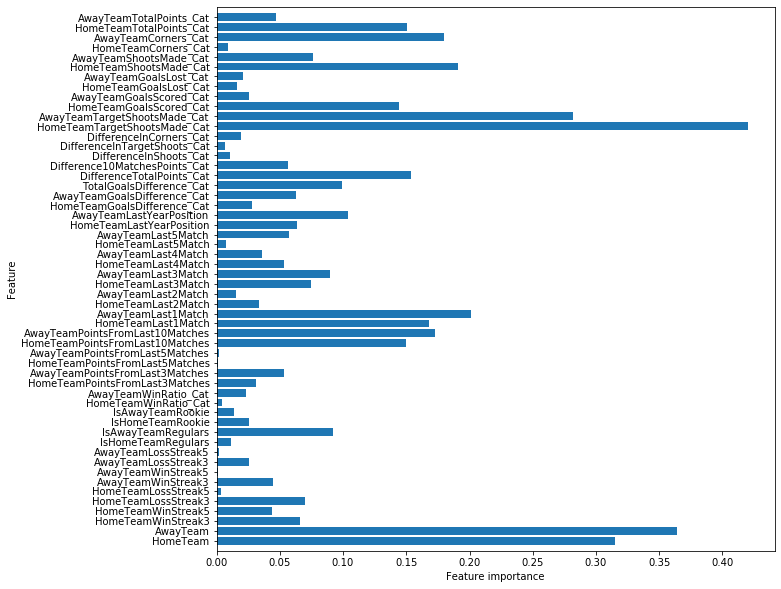

Number of features before reduction: 54


In [40]:
# funtion from preprocessing.py
plot_feature_importances(clf, X_train.columns)

print('Number of features before reduction:', len(X_train.columns))

#### 4.2.4.3 Reduce number of features using perturbation technique

In [41]:
# function return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeam', 'AwayTeam', 'HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'HomeTeamLossStreak5', 'AwayTeamWinStreak3', 'AwayTeamWinStreak5', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'AwayTeamWinRatio_Cat', 'AwayTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'AwayTeamLast4Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference_Cat', 'AwayTeamGoalsDifference_Cat', 'TotalGoalsDifference_Cat', 'DifferenceTotalPoints_Cat', 'Difference10MatchesPoints_Cat', 'DifferenceInShoots_Cat', 'DifferenceInTargetShoots_Cat', 'DifferenceInCorners_Cat', 'HomeTeamTargetShootsMade_Cat', 'AwayTeamTargetShootsMade_Cat', 'HomeTeamGoalsScored_Cat', 'AwayTeamGoalsScored_Cat', 'Ho

#### 4.2.4.4 Show difference in accuracy and log loss after shuffling each features

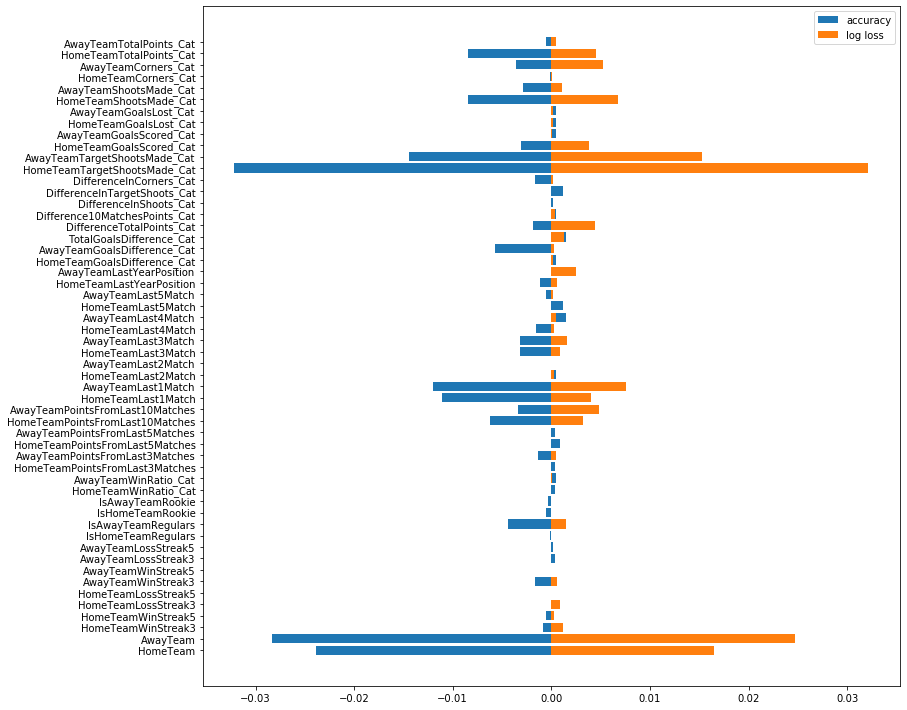

In [42]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.2.4.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [43]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

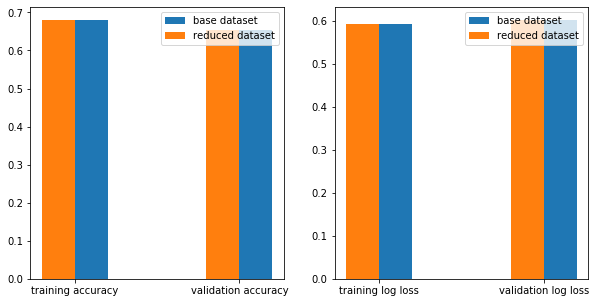

In [44]:
# fit new model on reduced dataset
clf = LogisticRegression(random_state=42, C=0.1, max_iter=1000, verbose=0)
clf.fit(X_train_red, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red, 
                                                                                                              y_train, 
                                                                                                              X_valid_red, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)

### 4.2.5 Perform features selection for KNeighborsClassifier model using perturbation technique

#### 4.2.5.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [45]:
clf = KNeighborsClassifier(n_neighbors=9, metric='manhattan', leaf_size=35)
clf.fit(X_train, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train, 
                                                                                                  y_train, 
                                                                                                  X_valid, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for KNeighborsClassifier
Accuracy score on train set: 0.72
Accuracy score on valid set: 0.66
Base log loss result on train set: 0.54
Base log loss result on valid set: 0.93


#### 4.2.5.2 Reduce number of features using perturbation technique

In [46]:
# function return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeam', 'AwayTeam', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'AwayTeamWinStreak3', 'AwayTeamWinStreak5', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsHomeTeamRookie', 'IsAwayTeamRookie', 'HomeTeamWinRatio_Cat', 'AwayTeamWinRatio_Cat', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference_Cat', 'AwayTeamGoalsDifference_Cat', 'TotalGoalsDifference_Cat', 'Difference10MatchesPoints_Cat', 'DifferenceInCorners_Cat', 'HomeTeamTargetShootsMade_Cat', 'AwayTeamTargetShootsMade_Cat', 'HomeTeamGoalsScored_Cat', 'AwayTeamGoalsScored_Cat', 'HomeTeamGoalsLost_Cat', 'AwayTeamGoalsLost_Cat', 'AwayTeamShootsMade

#### 4.2.5.3 Show difference in accuracy and log loss after shuffling each features

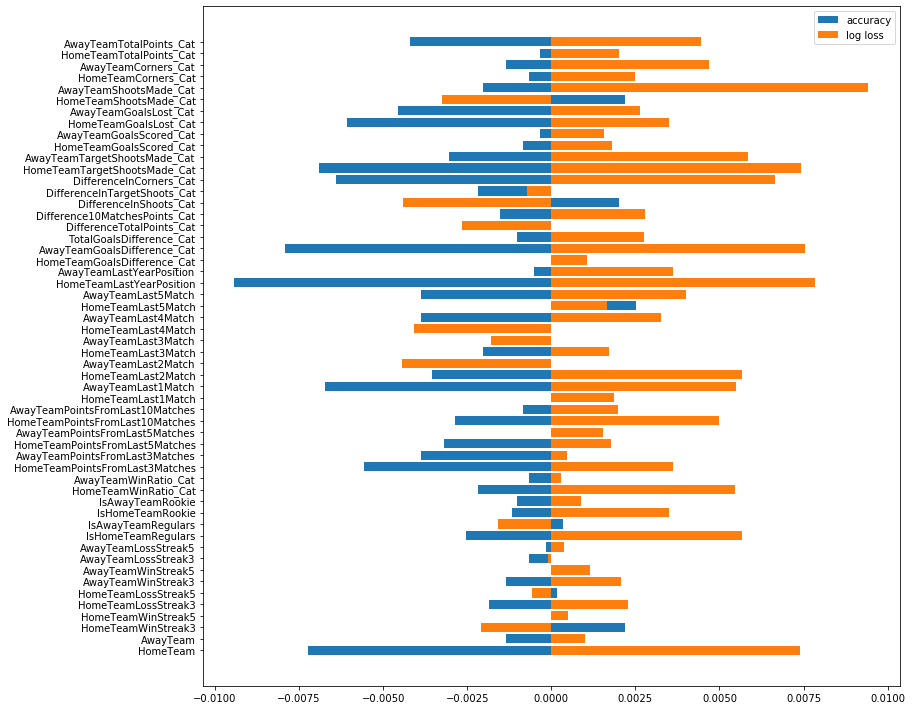

In [47]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.2.5.4 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [48]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

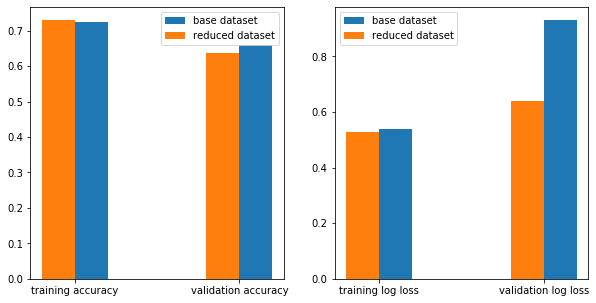

In [49]:
# fit new model on reduced dataset
clf = KNeighborsClassifier(n_neighbors=9, metric='manhattan', leaf_size=35)
clf.fit(X_train_red, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red, 
                                                                                                              y_train, 
                                                                                                              X_valid_red, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)

### 4.2.6 Perform features selection for SVC model with rbf kernel using perturbation technique

#### 4.2.6.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [50]:
clf = SVC(kernel='rbf', gamma=0.01, C=100, probability=True, max_iter=1000000, random_state=42)
clf.fit(X_train, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train, 
                                                                                                  y_train, 
                                                                                                  X_valid, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for SVC
Accuracy score on train set: 0.96
Accuracy score on valid set: 0.62
Base log loss result on train set: 0.46
Base log loss result on valid set: 0.67


#### 4.2.6.2 Reduce number of features using perturbation technique

In [51]:
# function return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeam', 'AwayTeam', 'HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'HomeTeamLossStreak5', 'AwayTeamWinStreak3', 'AwayTeamWinStreak5', 'AwayTeamLossStreak3', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'IsHomeTeamRookie', 'IsAwayTeamRookie', 'HomeTeamWinRatio_Cat', 'AwayTeamWinRatio_Cat', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference_Cat', 'AwayTeamGoalsDifference_Cat', 'TotalGoalsDifference_Cat', 'DifferenceTotalPoints_Cat', 'Difference10MatchesPoints_Cat', 'DifferenceInShoots_Cat', 'Di

#### 4.2.6.3 Show difference in accuracy and log loss after shuffling each features

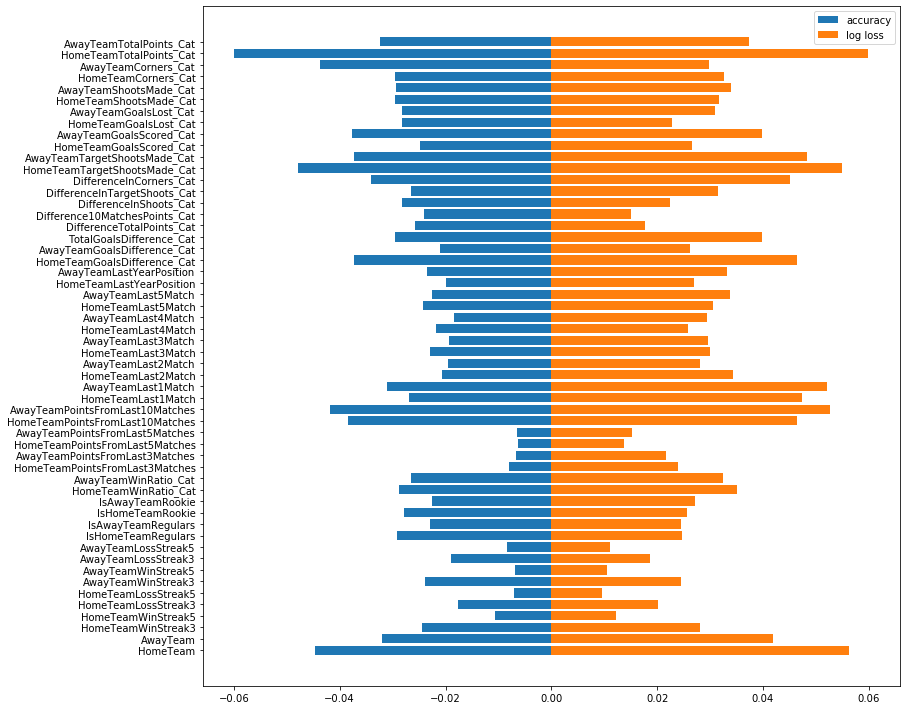

In [52]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.2.6.4 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [53]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

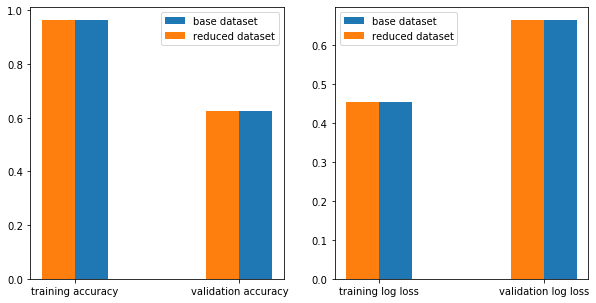

In [54]:
# fit new model on reduced dataset
clf = SVC(kernel='rbf', gamma=0.01, C=100, probability=True, max_iter=1000000, random_state=42)
clf.fit(X_train_red, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red, 
                                                                                                              y_train, 
                                                                                                              X_valid_red, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)

###  4.3 Features selection for deep learning models

### 4.3.1 Read datasets for deep learning models

In [55]:
train_set = pd.read_csv("./preprocessed_data/processed_base_train_set.csv", index_col=0)
validation_set = pd.read_csv("./preprocessed_data/processed_base_validation_set.csv", index_col=0)
test_set = pd.read_csv("./preprocessed_data/processed_base_test_set.csv", index_col=0)

In [56]:
train_set.head()

,FTR,HomeTeamWinStreak3,HomeTeamWinStreak5,HomeTeamLossStreak3,HomeTeamLossStreak5,AwayTeamWinStreak3,AwayTeamWinStreak5,AwayTeamLossStreak3,AwayTeamLossStreak5,IsHomeTeamRegulars,...,HomeTeamGoalsLost,AwayTeamGoalsLost,HomeTeamShootsMade,AwayTeamShootsMade,HomeTeamTargetShootsMade,AwayTeamTargetShootsMade,HomeTeamCorners,AwayTeamCorners,HomeTeamTotalPoints,AwayTeamTotalPoints
0,1.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,-0.654654,...,-1.520338,-1.321356,-1.166204,-1.288115,-0.915460,-1.077353,-1.563681,-1.704033,-1.231720,-1.409469
1,1.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,-0.654654,...,-1.122373,-1.454010,-1.257637,-1.227160,-1.023389,-1.023389,-1.405785,-1.528593,-1.409469,-1.113220
2,0.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,1.527525,...,-1.321356,-1.652993,-1.349071,-1.013815,-1.077353,-0.807532,-1.493505,-1.546137,-1.290969,-1.053971
3,0.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,-0.654654,...,-1.520338,-1.321356,-1.196682,-1.166204,-0.969424,-0.915460,-1.405785,-1.633857,-1.290969,-1.468718
4,1.0,-0.280755,-0.145413,-0.262896,-0.130856,-0.279706,-0.137995,-0.252117,-0.10841,-0.654654,...,-1.255028,-1.586665,-1.135726,-1.227160,-0.807532,-0.915460,-1.300521,-1.546137,-1.527968,-1.113220


### 4.3.2 Split datasets to feature and label sets

In [57]:
X_train, y_train = train_set.drop(columns='FTR'), np.array(train_set['FTR'])
X_valid, y_valid = validation_set.drop(columns='FTR'), np.array(validation_set['FTR'])
X_test, y_test = test_set.drop(columns='FTR'), np.array(test_set['FTR'])

# deep learning model need numpy array as input
X_train_np = np.array(X_train)
X_valid_np = np.array(X_valid)
X_test_np = np.array(X_test)

### 4.3.3 Perform feature reduction for simple ANN model using perturbation technique

#### 4.3.3.1 Fit deep learning classifier on train set and check accuracy score on train and valid set

In [58]:
# define stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

# build a classifier
clf = KerasClassifier(build_fn=build_ann,
                      validation_split=0.1, 
                      input_shape=X_train.shape[1:],
                      epochs=50, 
                      shuffle=True, 
                      callbacks=[early_stopping],
                      verbose=0,
                      n_hiden_layers=2,
                      hidden_layer_size=32,
                      batch_size=16)

clf.fit(X_train_np, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train_np, 
                                                                                                  y_train, 
                                                                                                  X_valid_np, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for KerasClassifier
Accuracy score on train set: 0.68
Accuracy score on valid set: 0.68
Base log loss result on train set: 0.59
Base log loss result on valid set: 0.59


#### 4.3.3.2 Reduce number of features using perturbation technique

In [59]:
# function return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction_deep_learning(clf, X_train_np, 
                                                                                             y_train, 
                                                                                             base_acc_train, 
                                                                                             base_log_loss_train,
                                                                                             kind ='ann')
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'AwayTeamWinStreak3', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsHomeTeamRookie', 'IsAwayTeamRookie', 'HomeTeamWinRatio', 'AwayTeamWinRatio', 'HomeTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference', 'AwayTeamGoalsDifference', 'TotalGoalsDifference', 'DifferenceTotalPoints', 'Difference1MatchPoints', 'Difference3MatchesPoints', 'Difference5MatchesPoints', 'Difference10MatchesPoints', 'DifferenceInCorners', 'DifferenceInLastYearPosition', 'HomeTeam', 'AwayTeam', 'HomeTeamGoalsScored', 'HomeTeamGoalsLost', 'AwayTeamGoalsLost', 'HomeTeamShoot

#### 4.3.3.3 Show difference in accuracy and log loss after shuffling each features

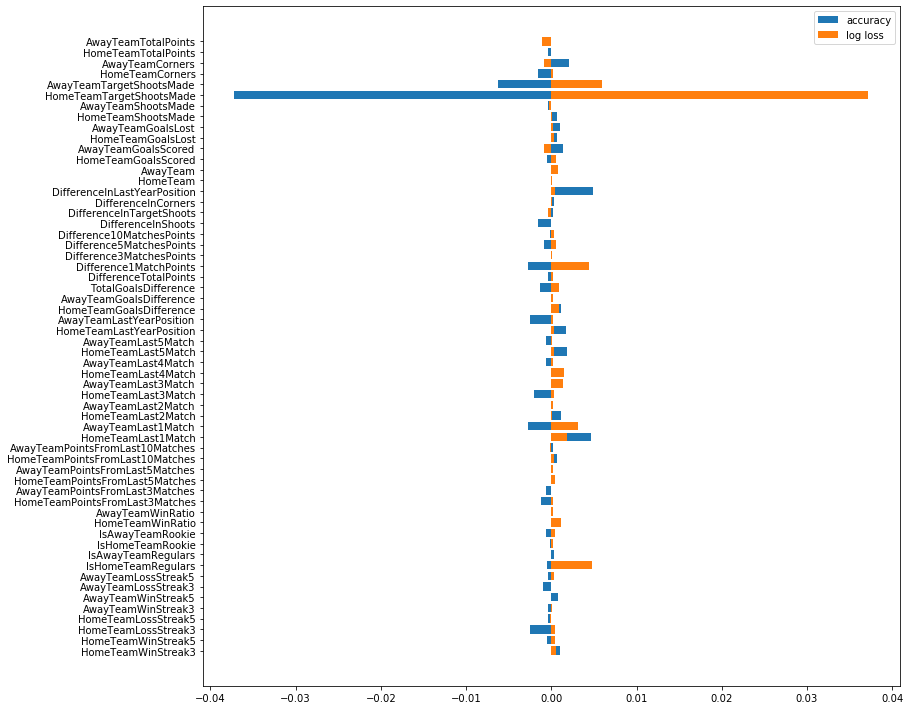

In [60]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction_deep_learning() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.3.3.4 Compare accuracy for model fitting on whole and reduced dataset

In [61]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

# deep learning model need numpy array as input
X_train_red_np = np.array(X_train_red)
X_valid_red_np = np.array(X_valid_red)
X_test_red_np = np.array(X_test_red)

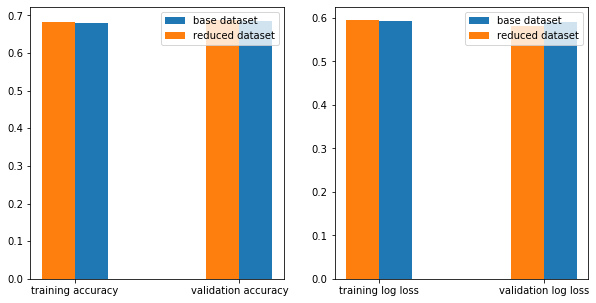

In [62]:
# fit new model on reduced dataset
clf = KerasClassifier(build_fn=build_ann,
                      validation_split=0.1, 
                      input_shape=X_train_red.shape[1:],
                      epochs=50, 
                      shuffle=False, 
                      callbacks=[early_stopping],
                      verbose=0,
                      n_hiden_layers=1,
                      hidden_layer_size=32,
                      batch_size=8)
clf.fit(X_train_red_np, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red_np, 
                                                                                                              y_train, 
                                                                                                              X_valid_red_np, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)

### 4.3.4 Perform feature reduction for simple RNN model using perturbation technique

#### 4.3.4.1 Fit deep learning classifier on train set and check accuracy score on train and valid set

In [63]:
# RNN network need 3d array as input
X_train_np_3d = X_train_np.reshape(X_train_np.shape[0], 1, X_train_np.shape[1])
X_valid_np_3d = X_valid_np.reshape(X_valid_np.shape[0], 1, X_valid_np.shape[1])

# define stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

# build a classifier
clf = KerasClassifier(build_fn=build_rnn,
                      validation_data=(X_valid_np_3d, y_valid), 
                      input_shape=X_train_np_3d.shape[1:],
                      epochs=50, 
                      shuffle=True, 
                      callbacks=[early_stopping],
                      verbose=0,
                      n_lstm_layers=2, 
                      lstm_layer_size=64,
                      n_hiden_layers=0,
                      hidden_layer_size=0,
                      batch_size=16)

clf.fit(X_train_np_3d, y_train)

# function calculate accuracy and log loss for training and validation sets
base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                  X_train_np_3d, 
                                                                                                  y_train, 
                                                                                                  X_valid_np_3d, 
                                                                                                  y_valid)
# function printing accuracy and log loss score for training and validation sets
show_base_metrics(clf, base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid)

Base test for KerasClassifier
Accuracy score on train set: 0.78
Accuracy score on valid set: 0.72
Base log loss result on train set: 0.47
Base log loss result on valid set: 0.6


#### 4.3.4.2 Reduce number of features using perturbation technique

In [64]:
# function from helpers.py, return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction_deep_learning(clf, X_train_np_3d, 
                                                                                             y_train, 
                                                                                             base_acc_train, 
                                                                                             base_log_loss_train,
                                                                                             kind = 'rnn')
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'HomeTeamLossStreak5', 'AwayTeamWinStreak3', 'AwayTeamWinStreak5', 'AwayTeamLossStreak3', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'IsHomeTeamRookie', 'IsAwayTeamRookie', 'HomeTeamWinRatio', 'AwayTeamWinRatio', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference', 'AwayTeamGoalsDifference', 'TotalGoalsDifference', 'DifferenceTotalPoints', 'Difference1MatchPoints', 'Difference3MatchesPoints', 'Difference5MatchesPoints', 'Difference10MatchesPoints',

#### 4.3.4.3 Show difference in accuracy and log loss after shuffling each features

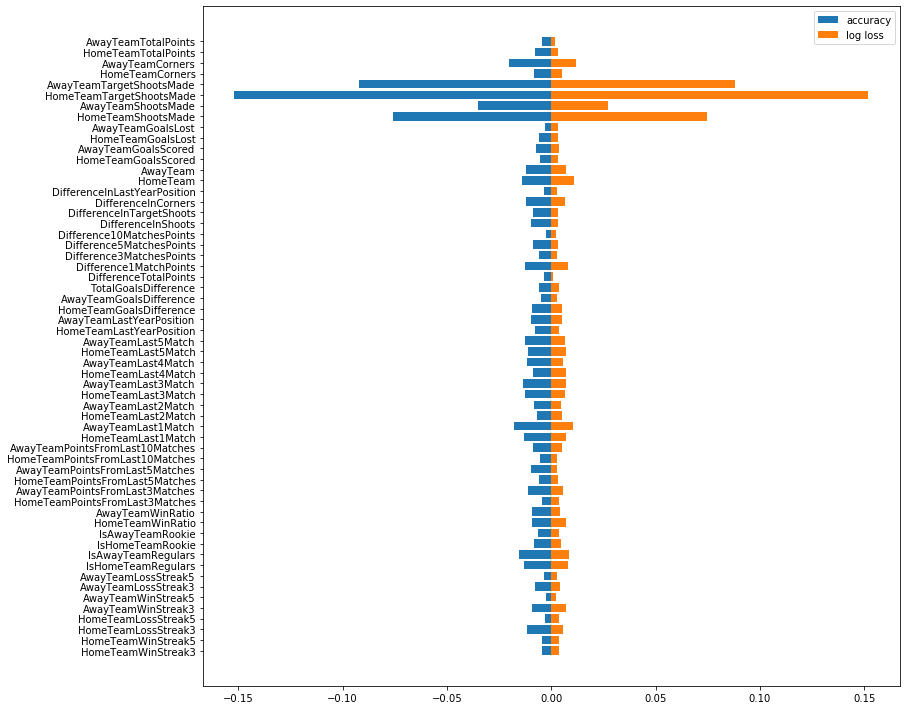

In [65]:
# function show difference between acc and log loss after shuffling each feature
show_diff_after_shuffling(diff_acc_results, diff_log_loss_results, X_train.columns)

Function <b> feature_reduction_deep_learning() </b> remain features for which after shuffle log_loss difference is grather than 0

#### 4.3.4.4 Compare accuracy for model fitting on whole and reduced dataset

In [66]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

# deep learning model need numpy array as input
X_train_red_np_3d = np.array(X_train_red).reshape(X_train_red.shape[0],1,X_train_red.shape[1])
X_valid_red_np_3d = np.array(X_valid_red).reshape(X_valid_red.shape[0],1,X_valid_red.shape[1])
X_test_red_np_3d = np.array(X_test_red).reshape(X_test_red.shape[0],1 ,X_test_red.shape[1])

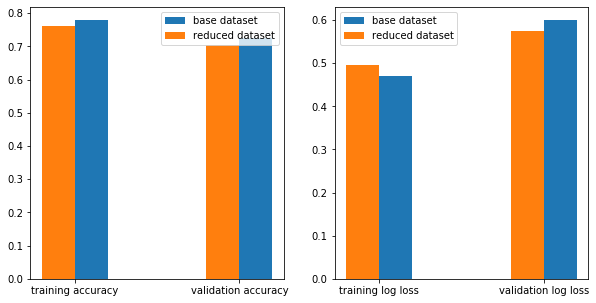

In [67]:
# fit new model on reduced dataset
clf = KerasClassifier(build_fn=build_rnn,
                      validation_data=(X_valid_red_np_3d, y_valid), 
                      input_shape=X_train_red_np_3d.shape[1:],
                      epochs=50, 
                      shuffle=True, 
                      callbacks=[early_stopping],
                      verbose=0,
                      n_lstm_layers=2, 
                      lstm_layer_size=64,
                      n_hiden_layers=0,
                      hidden_layer_size=0,
                      batch_size=16)
clf.fit(X_train_red_np_3d, y_train)

# function calculate accuracy and log loss for training and validation sets
reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid = calculate_base_metrics(clf, 
                                                                                                              X_train_red_np_3d, 
                                                                                                              y_train, 
                                                                                                              X_valid_red_np_3d, 
                                                                                                              y_valid)

# function show difference in accuracy and log loss between training and validation sets
show_acc_log_loss_difference(base_acc_train, base_acc_valid, base_log_loss_train, base_log_loss_valid,
                             reduced_acc_train, reduced_acc_valid, reduced_log_loss_train, reduced_log_loss_valid)